#### Vivian Xia

## Home Equity Line: Models




### Import packages

In [1]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier 

In [2]:
sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Import data

In [9]:
df = pd.read_csv('clean_HMEQ_Loss.csv')
print(df.head())

   TARGET_BAD_FLAG  TARGET_LOSS_AMT  LOAN  z_IMP_REASON_HomeImp  \
0                1            641.0  1100                     1   
1                1           1109.0  1300                     1   
2                1            767.0  1500                     1   
3                1           1425.0  1500                     0   
4                0              NaN  1700                     1   

   z_IMP_REASON_MISSING  z_IMP_JOB_Mgr  z_IMP_JOB_Office  z_IMP_JOB_Other  \
0                     0              0                 0                1   
1                     0              0                 0                1   
2                     0              0                 0                1   
3                     1              0                 0                0   
4                     0              0                 1                0   

   z_IMP_JOB_ProfExe  z_IMP_JOB_Sales  z_IMP_JOB_Self  M_MORTDUE  IMP_MORTDUE  \
0                  0                0               0

In [10]:
#create a variable for target columns to make it easier to refer to in the future
TARGET_FLAG = 'TARGET_BAD_FLAG'
TARGET_LOSS = 'TARGET_LOSS_AMT'

## Split Data

In [11]:
X = df.copy()
X = X.drop( TARGET_FLAG, axis=1 )
X = X.drop( TARGET_LOSS, axis=1 )

Y = df[ [TARGET_FLAG, TARGET_LOSS] ]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)

print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape )
print( "TEST = ", X_test.shape )

FLAG DATA
TRAINING =  (4768, 27)
TEST =  (1192, 27)


4768 records and 1192 records for training and testing respectively with 27 variables.

For target loss, only take the non-missing values because those are the loans that did default and have a resulting loss amount.

In [16]:
F = ~ Y_train[TARGET_LOSS].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_LOSS ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

In [14]:
print( Z_train.describe() )
print( Z_test.describe() ) 

       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            941.0       941.000000
mean               1.0     13421.645058
std                0.0     10662.481428
min                1.0       224.000000
25%                1.0      5817.000000
50%                1.0     10959.000000
75%                1.0     17635.000000
max                1.0     73946.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count            248.0       248.000000
mean               1.0     13387.758065
std                0.0     11508.703991
min                1.0       320.000000
25%                1.0      5214.500000
50%                1.0     11336.500000
75%                1.0     16734.000000
max                1.0     78987.000000


The max and the 75% quartile values have a pretty big difference, but due to the scenario where the loss amount is not capped, and its lack of effect on the tree models (which is more evident when looking at the diagrams later in this assignment), I did not think fixing the outliers was needed. 

## Decision Trees


Tree Based Models:


*   Simple Decision Trees
*   Random Forests
*   Gradient Boosting


### Loan Default Probability

In [17]:
fm01_Tree = tree.DecisionTreeClassifier( max_depth=4 )
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] ) # fit the tree with training data and flag variable

Y_Pred_train = fm01_Tree.predict(X_train) 
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8928271812080537
Accuracy Test: 0.886744966442953


In [18]:
# build an ROC curve
probs = fm01_Tree.predict_proba(X_train) # predict probability value
p1 = probs[:,1] # only want the probability of loan default
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_FLAG], p1) # give the data of what really happened and the p1 scores
roc_auc_train = metrics.auc(fpr_train, tpr_train) # find area under the ROC curve
print("Area under ROC curve for training data:", roc_auc_train)

probs = fm01_Tree.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_FLAG], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
print("Area under ROC curve for testing data:", roc_auc_test)

Area under ROC curve for training data: 0.8579061131448429
Area under ROC curve for testing data: 0.8275035025970475


In [19]:
fpr_tree = fpr_test
tpr_tree = tpr_test
auc_tree = roc_auc_test

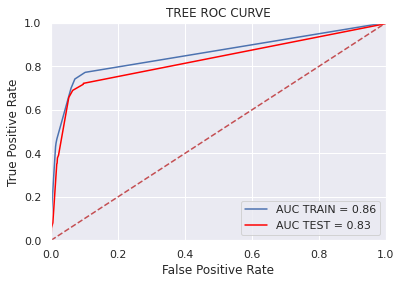

In [20]:
plt.title('TREE ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve shows the accuracy of the training and testing data on predicting the probability that the loan will default. The model looks reasonable. The training set did only a little better than the testing set, so the model is not overfit.

Visualize the actual tree and export it as a txt file and then use graphviz to visualize.

In [23]:
# get tree diagram
feature_cols = list( X.columns.values ) # use variable names
tree.export_graphviz(fm01_Tree,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"]  )

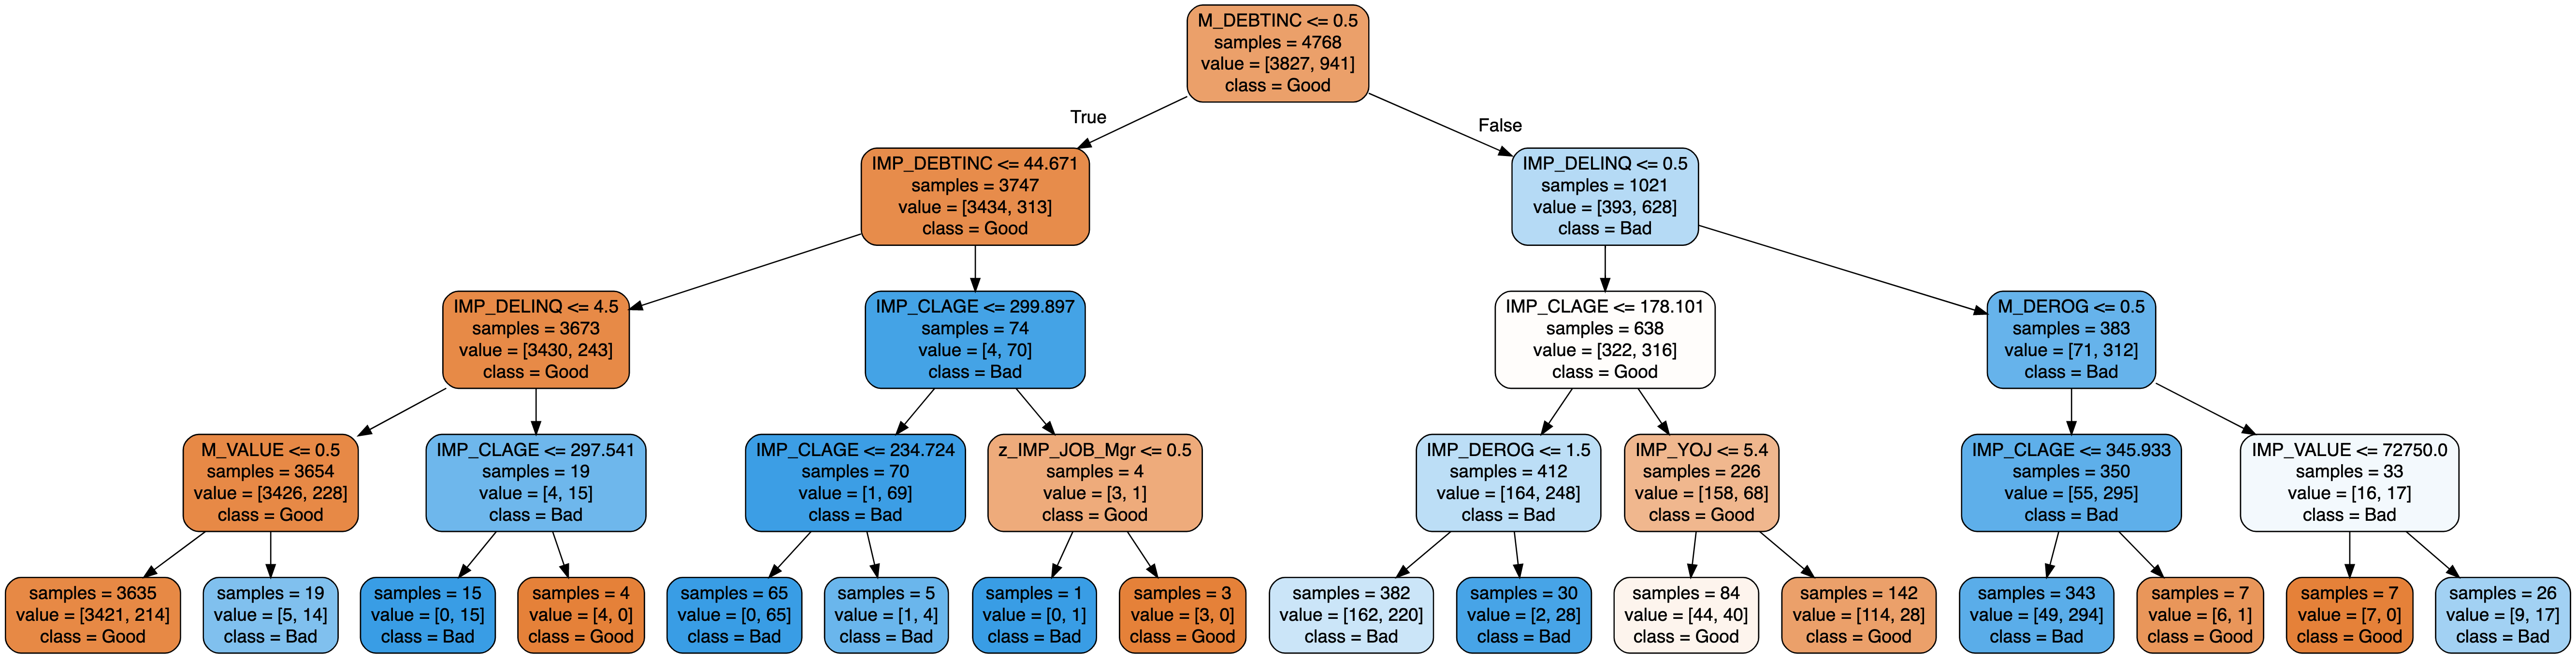

From first glance, the decision tree diagram for whether someone’s loan defaults looks like it makes sense because the colors generally get more concentrated/darker to the bottom. 

At the top, the value [3827, 941] means that 3827 people did not have their loans default and 941 did so 20% that had their loan default. The attribute of IMP_DEBTINC, is the first to be used to split the data depending on whether the debt-to-income ratio is less than or equal to 44.671.  The split puts those 3747 users that do have a debt-to-income ratio less than or equal to 44.671 in the class of Good, so these users have a higher chance of not having their loan default since 313 had their loan default while 3434 did not, so the chance of defaulting drop from 20% to 8%. This split makes sense since those who have higher debt-to-income ratio may tend to be riskier and less likely able to pay their bills. 

The other splits and variables used to split make sense in deciding if the user is more likely to have their loan default or not. 


In [24]:
# seach variables used in the model
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

In [25]:
vars_tree_flag = getTreeVars( fm01_Tree, feature_cols )

for i in vars_tree_flag :
    print(i)

z_IMP_JOB_Mgr
M_VALUE
IMP_VALUE
IMP_YOJ
M_DEROG
IMP_DEROG
IMP_DELINQ
IMP_CLAGE
M_DEBTINC
IMP_DEBTINC


These variables were used in the tree, and therefore, the most predictive of loan default. These variables make sense in splitting the data into the two classes.

### Predict Loss Amount

In [26]:
amt_m01_Tree = tree.DecisionTreeRegressor( max_depth= 4 )
amt_m01_Tree = amt_m01_Tree.fit( W_train, Z_train[TARGET_LOSS] )

Z_Pred_train = amt_m01_Tree.predict(W_train) 
Z_Pred_test = amt_m01_Tree.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_LOSS], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_LOSS], Z_Pred_test))

print("TREE RMSE Train:", RMSE_TRAIN )
print("TREE RMSE Test:", RMSE_TEST )

TREE RMSE Train: 4587.556685671267
TREE RMSE Test: 5763.9837632219205


In [27]:
RMSE_TREE = RMSE_TEST

feature_cols = list( X.columns.values )
vars_tree_amt = getTreeVars( amt_m01_Tree, feature_cols ) 
tree.export_graphviz(amt_m01_Tree,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0  )

for i in vars_tree_amt :
    print(i)

LOAN
z_IMP_REASON_MISSING
IMP_VALUE
IMP_NINQ
IMP_CLNO
M_DEBTINC
IMP_DEBTINC


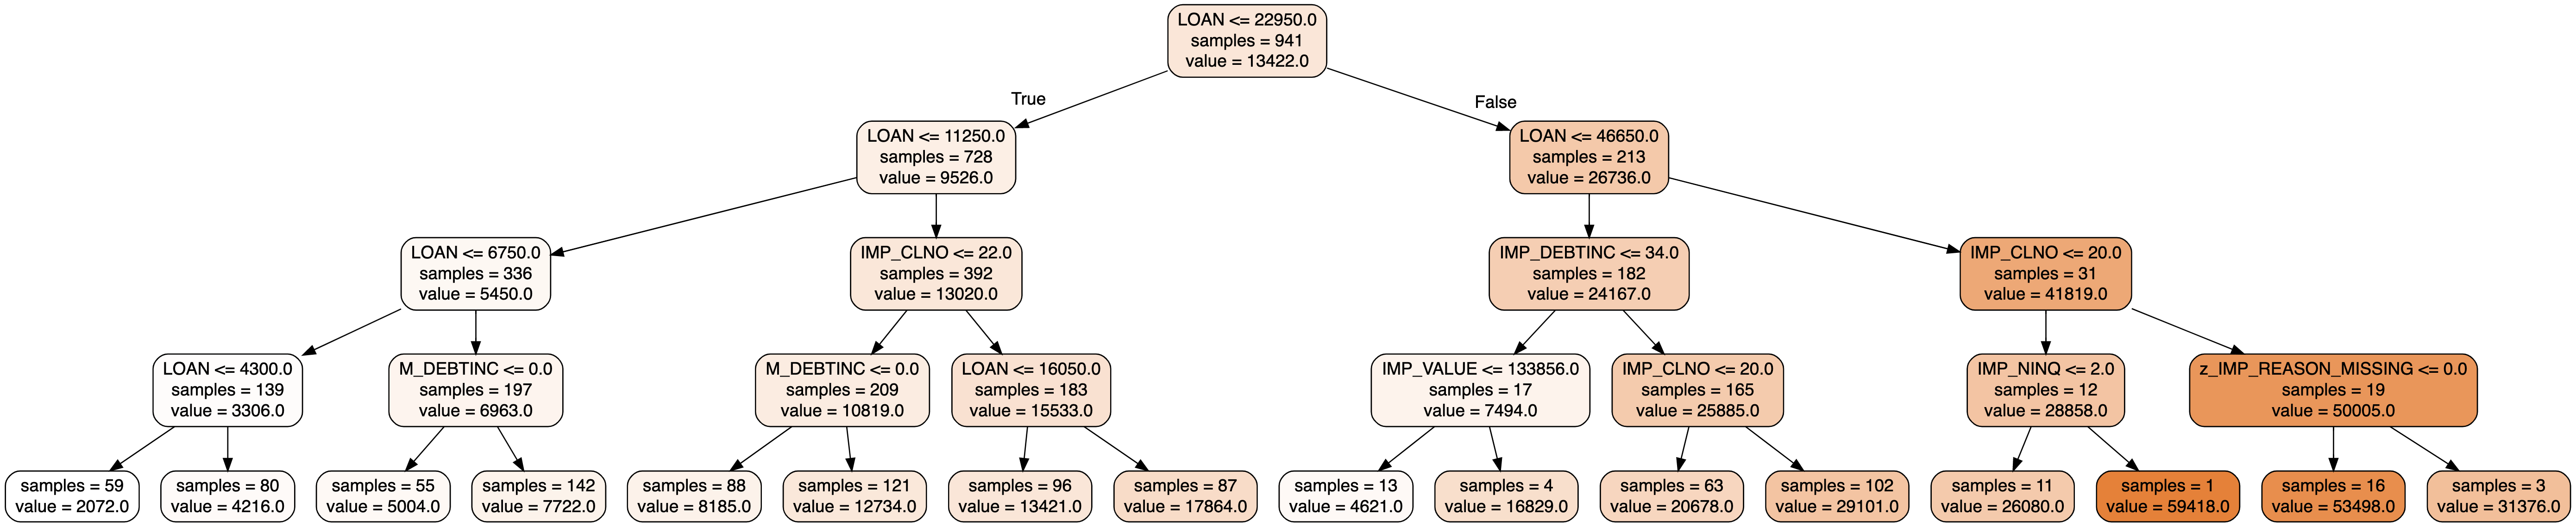

LOAN refers to the credit line. The greater the value the larger the loss amount and vice versa, which makes sense as a larger loan will result in a larger loss amount when defaulted. LOAN is then used again to split the data and a few other times as well, so LOAN seems to be the most predictive in the loss amount. The other variables also make sense in its use for predicting loss amount.

## Random Forests

#### Loan Default Probability

In [29]:
fm01_RF = RandomForestClassifier( n_estimators = 25, random_state=1 ) # n_estimators is the num of decision trees
fm01_RF = fm01_RF.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

print("RANDOM FOREST\n")
print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

RANDOM FOREST

Probability of loan default
Accuracy Train: 0.9991610738255033
Accuracy Test: 0.912751677852349


In [30]:
# create an ROC curve
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_FLAG], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_RF.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_FLAG], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

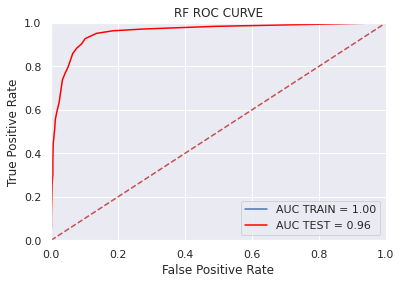

In [31]:
plt.title('RF ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The Random Forest area under the curve for the testing data set, 0.96, is greater than that of the decision tree, 0.83. The Random Forest test data had a higher accuracy than that of the Decision Tree test data. The Random Forest did better in predicting the loan default probability.

In [32]:
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) : 
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

In [33]:
feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( fm01_RF, feature_cols )

for i in vars_RF_flag :
    print( i )

('M_DEBTINC', 100)
('IMP_DEBTINC', 80)
('IMP_CLAGE', 44)
('IMP_DELINQ', 43)
('IMP_VALUE', 42)
('LOAN', 36)
('IMP_CLNO', 33)
('IMP_MORTDUE', 32)
('IMP_YOJ', 29)
('IMP_DEROG', 26)


#### Predict Loss Amount

In [34]:
amt_m01_RF = RandomForestRegressor(n_estimators = 100, random_state=1)
amt_m01_RF = amt_m01_RF.fit( W_train, Z_train[TARGET_LOSS] )

Z_Pred_train = amt_m01_RF.predict(W_train)
Z_Pred_test = amt_m01_RF.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_LOSS], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_LOSS], Z_Pred_test))
RMSE_RF = RMSE_TEST

print("RF RMSE Train:", RMSE_TRAIN )
print("RF RMSE Test:", RMSE_TEST )

RF RMSE Train: 1224.2045361008875
RF RMSE Test: 3261.0178490237076


The testing data using the Random Forest model was more accurate than when using the Decision Tree.


In [35]:
feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( amt_m01_RF, feature_cols )

for i in vars_RF_amt :
    print( i )

('LOAN', 100)
('IMP_CLNO', 12)
('IMP_DEBTINC', 5)


LOAN, IMP_CLNO, and IMP_DEBTINC were included in the Random Forest to predict loss amount. LOAN was the most used and predictive in the regressor. The use of LOAN and IMP_CLNO make sense in predicting loss amount since they reflect the size of the loan. IMP_DEBTINC also makes sense since a user with high debt-to-income ratio may not be able to pay their bills so it reflects that the user may be taking larger loans.

## Gradient Boosting

#### Loan Default Probability

In [36]:
fm01_GB = GradientBoostingClassifier( random_state=1 )
fm01_GB = fm01_GB.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_GB.predict(X_train)
Y_Pred_test = fm01_GB.predict(X_test)

print("GRADIENT BOOSTING\n")
print("Probability of default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

GRADIENT BOOSTING

Probability of default
Accuracy Train: 0.9236577181208053
Accuracy Test: 0.9035234899328859


In [37]:
probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_FLAG], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_FLAG], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test

In [38]:
feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( fm01_GB, feature_cols )

for i in vars_GB_flag :
    print(i)

('M_DEBTINC', 100)
('IMP_DEBTINC', 29)
('IMP_DELINQ', 19)
('IMP_CLAGE', 13)


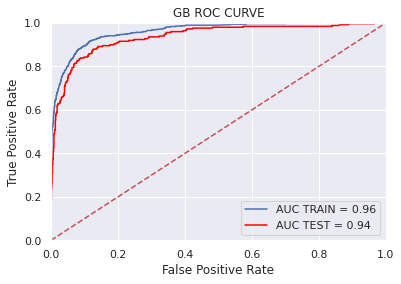

In [39]:
plt.title('GB ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Its AUC is 0.94, so it does better than the Decision Tree test data set but not as well as the Random Forest's.

#### Predict Loss Amount

In [40]:
amt_m01_GB = GradientBoostingRegressor(random_state=1)
amt_m01_GB = amt_m01_GB.fit( W_train, Z_train[TARGET_LOSS] )

Z_Pred_train = amt_m01_GB.predict(W_train)
Z_Pred_test = amt_m01_GB.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_LOSS], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_LOSS], Z_Pred_test))
RMSE_GB = RMSE_TEST

print("GB RMSE Train:", RMSE_TRAIN )
print("GB RMSE Test:", RMSE_TEST )

GB RMSE Train: 1218.1569933684325
GB RMSE Test: 2531.037788531138


The accuracy for the testing data for Gradient Boosting is better than the accuracy for the testing data for Random Forest and Decision Tree.

In [41]:
feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( amt_m01_GB, feature_cols )

for i in vars_GB_amt :
    print(i)

('LOAN', 100)
('IMP_CLNO', 14)
('IMP_DEBTINC', 5)
('M_DEBTINC', 5)


## ROC Curves

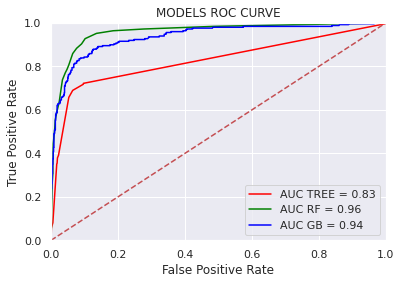

In [42]:
plt.title('MODELS ROC CURVE')
plt.plot(fpr_tree, tpr_tree, 'b', label = 'AUC TREE = %0.2f' % auc_tree, color="red")
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC RF = %0.2f' % auc_RF, color="green")
plt.plot(fpr_GB, tpr_GB, 'b', label = 'AUC GB = %0.2f' % auc_GB, color="blue")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Forest is the most accurate, but Gradient Boosting is a close second, for predicting loan default probability.


In [43]:
print("Root Mean Square Average For Loss Amounts")
print("TREE", RMSE_TREE)
print("RF", RMSE_RF)
print("GB", RMSE_GB)

Root Mean Square Average For Loss Amounts
TREE 5763.9837632219205
RF 3261.0178490237076
GB 2531.037788531138


Gradient Boosting has the lowest the Root Mean Square and thus, the most accurate in predicting the loss amount.

## Decision Tree Classifier - change max_depth

###### Let Python decide

In [45]:
fm01_Tree = tree.DecisionTreeClassifier() 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 1.0
Accuracy Test: 0.8699664429530202


Area under ROC curve for training data: 1.0
Area under ROC curve for testing data: 0.7752016129032258


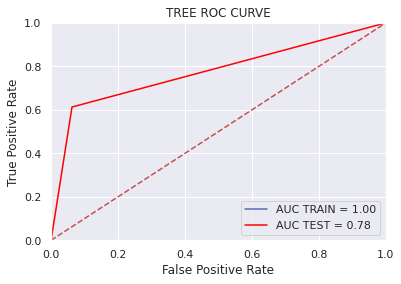

In [46]:
probs = fm01_Tree.predict_proba(X_train)
p1 = probs[:,1] 
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_FLAG], p1) 
roc_auc_train = metrics.auc(fpr_train, tpr_train) 
print("Area under ROC curve for training data:", roc_auc_train)

probs = fm01_Tree.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_FLAG], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)
print("Area under ROC curve for testing data:", roc_auc_test)

plt.title('TREE ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
# seach variables for the model
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list


vars_tree_flag = getTreeVars( fm01_Tree, feature_cols ) 

for i in vars_tree_flag :
    print(i)

LOAN
z_IMP_REASON_HomeImp
z_IMP_REASON_MISSING
z_IMP_JOB_Mgr
z_IMP_JOB_Office
z_IMP_JOB_Other
z_IMP_JOB_ProfExe
z_IMP_JOB_Sales
z_IMP_JOB_Self
M_MORTDUE
IMP_MORTDUE
M_VALUE
IMP_VALUE
M_YOJ
IMP_YOJ
M_DEROG
IMP_DEROG
IMP_DELINQ
M_CLAGE
IMP_CLAGE
M_NINQ
IMP_NINQ
M_CLNO
IMP_CLNO
M_DEBTINC
IMP_DEBTINC


The accuracy for the training data is perfect, so there is a potential it overfit the training data. The large number of variables used to split the data shows the likelihood of overfitting. The accuracy for the test data did not do better than the accuracy of the original max_depth = 4 version, 0.89. Similarly, the area under the curve for the test data set is less than that of the original version, so the original version is more accurate and is a better predictor for the probability of loan default.

###### Accuracy of different max_depth

In [48]:
#max_depth = 2
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 2 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8670302013422819
Accuracy Test: 0.8481543624161074


In [49]:
#max_depth = 3
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 3 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8873741610738255
Accuracy Test: 0.8825503355704698


In [50]:
#max_depth = 4
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 4 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8928271812080537
Accuracy Test: 0.8859060402684564


In [51]:
#max_depth = 5
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 5 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8974412751677853
Accuracy Test: 0.8875838926174496


In [52]:
#max_depth = 6
fm01_Tree = tree.DecisionTreeClassifier( max_depth = 6 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.902265100671141
Accuracy Test: 0.8884228187919463


The test data set did the best with a max_depth = 6. However, there was barely a difference in accuracy from using max_depth = 4 or 5 or 6, so the simpler model should be used instead.

## Decision Tree & Random Forest Classifier - changing criterion = 'entropy'

The default for the criterion parameter is ‘Gini,’ which measured the quality of the split using Gini impurity to find the probability of misclassifying an observation. For this version, I ran the Decision Tree as well as the Random Forest Classifier with the criterion parameter “entropy,” which will measure the quality of the split using information gain.

In [53]:
fm01_Tree = tree.DecisionTreeClassifier( criterion='entropy', max_depth=4 ) 
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

Probability of loan default
Accuracy Train: 0.8886325503355704
Accuracy Test: 0.8825503355704698


The accuracy for the testing data decreased from the original model 0.8867 to the new model 0.8826. The Gini criterion gives a more accurate probability of loan default than the entropy criterion.

In [54]:
fm01_RF = RandomForestClassifier( criterion = 'entropy', n_estimators = 25, random_state=1 ) #n_estimators is the no. of decision trees
fm01_RF = fm01_RF.fit( X_train, Y_train[ TARGET_FLAG ] )

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

print("RANDOM FOREST\n")
print("Probability of loan default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_FLAG], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_FLAG], Y_Pred_test))

RANDOM FOREST

Probability of loan default
Accuracy Train: 0.9997902684563759
Accuracy Test: 0.912751677852349


There was no difference in the accuracy of the test sets with criterion = ‘entropy’ or ‘Gini.’